<a href="https://colab.research.google.com/github/OSGeoLabBp/tutorials/blob/master/english/data_processing/lessons/ransac_sphere.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RANCAS spheres

In this tutorial we will use robust algorithm two find spheres in a 3D scene. At the begining we'll create a function for regression sphere. Then we'll generate a noisy point cloud with spheres. Finaly spheres are searched by RANSAC.

First let's import the neccessary Python modules.


*   numpy - for arrays and maptrix operations
*   math - for mathematical functions
*   random - for spseudo random numbers
*   plotly - for 3D plots

In [17]:
import numpy as np
from math import sin, cos, pi, sqrt
from random import random, seed
import plotly.graph_objects as go

## Regression sphere

Similar way to circle we can find a regression sphere through four or more points. The equation of the sphere:

$(x−x_0)^2+(y−y_0)^2+(z−z_0)^2=r2$

Removing the brakets and reordering tags we get:

$y^2+x^2+z^2−2x_0x−2y_0y−2z_0z+x_0^2+y_0^2+z_0^2−r^2=0$

Let's make substitution to have linear formula:

$a_1=−2x_0$

$a_2=−2y_0$

$a_3=−2z_0$

$a_4=x_0^2+y_0^2+z_0^2−r^2$

$x^2+y^2+z^2+a_1x+a_2y+a_3z+a_4=0$

We can set up one equation for each point to find unknonws ($a_1, a_2, a_3, a_4$).

Let's write a Python function to solve the equation system using Least Squares Method (LSM).

In [27]:
def sphere(x_, y_, z_):
  """ x_, y_, z_ are numpy arrays of coordinates of four or more points """
  n_ = x_.shape[0]
  a = np.c_[x_, y_, z_, np.full(n_, 1, 'float64')]
  b = -np.square(x_) - np.square(y_) - np.square(z_)
  res = np.linalg.lstsq(a, b, rcond=None)[0]
  return -0.5 * res[0], -0.5 * res[1], -0.5 * res[2], \
          sqrt((res[0]**2 + res[1]**2 + res[2]**2)/4 - res[3])

Simple test for four points:

In [31]:
x_sp = np.array([102.167, 102.178, 102.145, 102.135])
y_sp = np.array([99.674, 99.754, 99.752, 99.675])
z_sp = np.array([58.389, 58.383, 58.411, 58.414])
x0, y0, z0, r = sphere(x_sp, y_sp, z_sp)
print("The equation of the sphere")
print(f"(x - {x0:.3f})^2 + (y - {y0:.3f})^2 + (z - {z0:.3f})^2 = {r:.3f}")
print("Residuals")
for x_i, y_i, z_i in zip(x_sp, y_sp, z_sp):
    print(f"{((x_i - x0)**2 + (y_i - y0)**2 +(z_i - z0)**2 - r**2):.3f}")

The equation of the sphere
(x - 101.985)^2 + (y - 99.725)^2 + (z - 58.187)^2 = 0.277
Residuals
-0.000
-0.000
-0.000
-0.000


Random number is initialized by actual time in seconds using seed. You can enter a constant parameter of seed(int) if you want to use the same points every time.

In [18]:
np.random.seed()
seed()

Let's generate random center points and radii for spheres. You can customize the extent of the scene, the number of spheres and the limitations of radius.

In [3]:
x_range, y_range, z_range = 100, 100, 100   # working in a x_range * y_range * z_range  metres box
n = 10                                  # number of spheres to generate
min_r = 3                               # minimum radius
max_r = 6                               # maximum radius
xc = np.random.rand(n) * x_range        # coordinates of center of spheres
yc = np.random.rand(n) * y_range
zc = np.random.rand(n) * z_range
r = np.round(min_r + np.random.rand(n) * (max_r - min_r), decimals=1) # radii

Let's generate random points with noise on the surface of the spheres. You can customize the number of points/sphere and max

## Random sample data

In [4]:
points_per_sphere = 100                 # number of points on thesurface of each sphere
max_noise =  0.1
x = np.zeros((n + 1) * points_per_sphere) # arrays to store points on surface
y = np.zeros((n + 1) * points_per_sphere) # and points_per_sphere number of random noise
z = np.zeros((n + 1) * points_per_sphere)
for i in range(n):                        # for each sphere
  for j in range(points_per_sphere):      # for the number of points on the sphere
    alpha = random() * pi * 2             # azimut for the point (0 - 360 degree)
    beta = random() * pi - pi / 2         # elevation angle (-90 - 90 degree)
    ind = i * points_per_sphere + j       # index for the point
    x[ind] = xc[i] + r[i] * cos(beta) * cos(alpha)  # point on surface
    y[ind] = yc[i] + r[i] * cos(beta) * sin(alpha)
    z[ind] = zc[i] + r[i] * sin(beta)
# extra random points
x[n*points_per_sphere: (n+1)*points_per_sphere] = np.random.rand(points_per_sphere) * x_range
y[n*points_per_sphere: (n+1)*points_per_sphere] = np.random.rand(points_per_sphere) * y_range
z[n*points_per_sphere: (n+1)*points_per_sphere] = np.random.rand(points_per_sphere) * z_range
# random noise to all points in -max_noise +max_noise range
x += np.random.rand((n+1)*points_per_sphere) * max_noise - max_noise / 2
y += np.random.rand((n+1)*points_per_sphere) * max_noise - max_noise / 2
# uncomment next line to save point cloud
#np.savetxt('sample_data/test.xyz', np.c_[x, y, z])

Let's check visually our point cloud using plotly. You can rotate, pan and zoom using mouse. IT IS NOT VISIBLE ON GitHub.

In [5]:
fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z, mode='markers',     
     marker=dict(size=2, color=z, colorscale='Viridis'))])
# Add title to the axes
fig.update_layout(scene=dict(
                    aspectmode='manual',
                    aspectratio=dict(x=1, y=1, z=1),
                    xaxis_title='X',
                    yaxis_title='Y',
                    zaxis_title='Z'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10)
)
fig.show()

Static view using matplotlib.

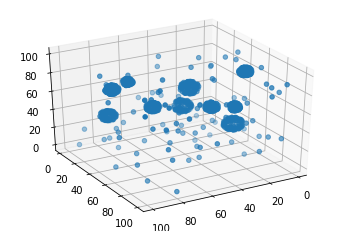

In [6]:
from matplotlib import pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(x, y, z)
ax.view_init(32, 60)              # change the two view directions (in degree)

## RANSAC

First try to make the necessary steps for the RANSAC algorithm. Let's select four random points for RANSAC.

In [8]:
def rand_pnts(x_, y_, z_, n_=4):
  """ select n_ points """
  m = x_.shape[0] # number of items
  l = []
  while len(l) != n_:
    l = list(set(np.random.randint(m, size=n_))) # remove repeated random integers
  return (x_[l], y_[l], z_[l])

Let's create a function to calculate the distances from the surface of a sphere to all points.

In [9]:
def ransac_dist(x_, y_, z_, sph_):
    """ calculate distance from the surface of sphere
        and returns distances as numpy vector
    """
    d_ = np.abs(np.sqrt(np.square(x_ - sph_[0]) + np.square(y_ - sph_[1]) + np.square(z_ - sph_[2])) - sph_[3])
    return d_

Now we start the RANSAC algorithm. We will try to find the spheres one by one. After founding one of them the points of the found sphere are removed, before searching for the next one. You can customize the iteration count and the tolerance. The lower the iteration count the less spheres found. The higher the iteration count the more the elapsed time of algorithm.

In [10]:
tol = max_noise / 2      # distance tolerance from the surface of sphere
max_iter = n * points_per_sphere * 4
x1 = np.copy(x) # preserve original coordinates
y1 = np.copy(y) # we work on a copy
z1 = np.copy(z)
spheres = []    # list for found spheres

We will repeat the search until enough points left or no more sphere found.

In [11]:
while x1.shape[0] > points_per_sphere // 2:
    best_n = 0
    for i in range(max_iter):
        x4, y4, z4 = rand_pnts(x1, y1, z1)  # four random points
        x0, y0, z0, r0 = sphere(x4, y4, z4) # parameters of sphere
        d4 = ransac_dist(x1, y1, z1, np.array([x0, y0, z0, r0]))
        on4 = d4 < tol                    # select close points to sphere
        act_n = d4[on4].shape[0]          # number of close points
        if act_n > best_n:
            best_n = act_n
            best_on = np.copy(on4)
            best_x0, best_y0, best_z0, best_r0 = x0, y0, z0, r0
    # radius in the given range and there are enough points on surface
    if best_n > points_per_sphere // 4:
        if min_r <= best_r0 <= max_r:
            spheres.append([best_x0, best_y0, best_z0, best_r0, best_n])
    else:
        break                       # few points left
    x1 = x1[np.invert(best_on)]     # remove used points
    y1 = y1[np.invert(best_on)]
    z1 = z1[np.invert(best_on)]

Finally let's write out the parameters of the found and the original spheres.

In [12]:
s = np.sort(np.array(spheres), axis=0)          # convert list to array
ss = np.sort(np.c_[xc, yc, zc, r], axis=0)      # put together original sphere data
print
print(f"Found spheres: {len(spheres)}")
print("   Found spheres                             Original spheres")
print("    x0       y0       z0       r       n      x0       y0       z0      r")
for i in range(max(n, len(spheres))):
    if i < len(spheres):
        buf = f"{s[i,0]:8.2f} {s[i,1]:8.2f} {s[i,2]:8.2f} {s[i,3]:8.2f} {int(s[i,4]):4d}"
    else:
        buf = f"{' ':42s}"
    if i < len(spheres): 
        buf += f"{ss[i,0]:8.2f} {ss[i,1]:8.2f} {ss[i,2]:8.2f} {ss[i,3]:6.2f}"
    print(buf)

Found spheres: 10
   Found spheres                             Original spheres
    x0       y0       z0       r       n      x0       y0       z0      r
   18.83     7.93    33.42     3.20   70   18.84     7.93    33.41   3.20
   24.72    11.46    36.57     3.37   91   24.70    11.45    36.56   3.40
   32.39    22.94    40.10     3.88   93   32.38    22.95    40.09   3.90
   35.56    23.28    41.19     4.10   93   35.57    23.31    41.18   4.10
   39.80    41.22    58.22     4.20   95   39.74    41.22    58.22   4.20
   43.35    50.87    63.92     4.39   96   43.37    50.85    63.92   4.40
   52.88    63.59    74.42     4.99   97   52.86    63.61    74.43   5.00
   61.78    70.46    76.70     5.80   98   61.78    70.47    76.70   5.80
   77.90    73.23    81.24     5.90   99   77.91    73.24    81.24   5.90
   89.99    95.88    95.51     6.00   99   90.03    95.93    95.50   6.00


**Tasks for practice**

*   Change the parameters (increase/decrease noise/tolerance/iteration count/etc) and run
*   Test the program on real data sets
*   Change the code to read data from text file
*   Get more accurate position for sphere using least squares estimation for all inliers
*   Change the code to use from the command line
*   Using Open3D load other point cloud format files for processing

